# Анализ Данных Клиентов


## Датасет

Таблица `user_data` содержит информацию о клиентах платформы.

- client: идентификатор пользователя
- premium: является ли клиент премиум
- age: возраст

Таблица `logs` содержит информацию об операциях клиентов платформы.

- client: идентификатор пользователя
- success: результат (успех - 1, нет - 0)
- platform: платформа
- time: время в формате Unix

In [2]:
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import requests
from urllib.parse import urlencode

In [3]:
def url_ydisk (url):    
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'
    public_key = url
    final_url = base_url + urlencode(dict(public_key=public_key))
    response = requests.get(final_url)
    download_url = response.json()['href']
    return download_url    

In [4]:
logs = pd.read_csv(url_ydisk('https://disk.yandex.ru/d/Dc6O9jHAGfWgyQ'))
logs.head()

,client,success,platform,time
0,40177,True,phone,1585412212
1,61468,True,phone,1585425658
2,35604,False,phone,1585459894
3,9961,True,phone,1585400189
4,10931,True,computer,1585468629


In [5]:
user_data = pd.read_csv(url_ydisk('https://disk.yandex.ru/d/gvlTf9t0ewyoaA'))
user_data.head()

,client,premium,age
0,46346,False,58
1,4391,False,55
2,27372,False,64
3,11989,False,44
4,60664,False,49


### 1 задание
Сколько уникальных значений принимает переменная platform? Если несколько пользователей совершили одинаковое число успешных действий, перечислите их идентификаторы (client) через запятую и пробел в порядке возрастания.



In [6]:
unique_platform = logs.platform.nunique()

In [7]:
print(f'Переменная platform принимает {unique_platform} уникальных значений.')

Переменная platform принимает 3 уникальных значений.


### 2 задание
Какой клиент совершил больше всего успешных операций? 

In [8]:
# Число успешных операций у каждого клиента 
success_users = logs.query('success == True') \
    .groupby('client') \
    .agg({'time':'count'}) \
    .rename(columns={'time': 'successful_operations'}) \
    .sort_values('successful_operations', ascending=False)
success_users.head()

,successful_operations
client,
12179,41
61468,41
52870,41
61473,41
92584,41


In [9]:
# Максимальное число успешных операций
max_successful_operations = success_users.iloc[0, 0]

ID клиентов, совершивших больше всего успешных операций:

In [16]:
print(*sorted(success_users.query('successful_operations == @max_successful_operations').index), sep=', ')

12179, 28719, 36165, 52870, 61468, 61473, 78349, 82563, 92584


### 3 задание
С какой платформы осуществляется наибольшее количество успешных операций?

In [18]:
#число успешных операций в каждой платформе 
platform_success_operations = logs.query('success == True') \
    .groupby('platform') \
    .agg({'client':'count'}) \
    .rename(columns={'client': 'successful_operations'}) \
    .sort_values('successful_operations', ascending=False)

platform_success_operations

,successful_operations
platform,
phone,2019
computer,1090
tablet,180


In [22]:
best_platform = platform_success_operations.successful_operations.idxmax()

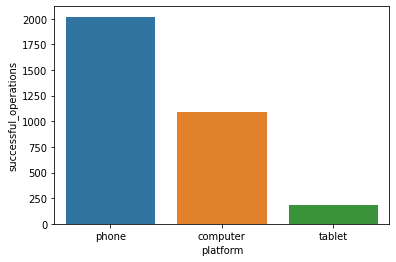

In [32]:
sns.barplot(data=platform_success_operations.reset_index(), x='platform', y='successful_operations')

In [33]:
print(f'Платформа с наибольшим количеством успешных операций: {best_platform}.')

Платформа с наибольшим количеством успешных операций: phone.


### 4 задание
Какую платформу предпочитают премиумные клиенты?

In [25]:
users_logs = user_data.merge(logs, on='client')
users_logs.head()

,client,premium,age,success,platform,time
0,46346,False,58,True,phone,1585452839
1,4391,False,55,False,phone,1585409861
2,27372,False,64,False,phone,1585446018
3,11989,False,44,True,computer,1585403698
4,60664,False,49,True,phone,1585406918


In [35]:
# Число операций премиум клиентов на каждой из платформ 
platform_premium_operations = users_logs.query('premium == True') \
    .groupby('platform') \
    .agg({'client':'count'}) \
    .rename(columns={'client': 'operations'}) \
    .sort_values('operations', ascending=False)

platform_premium_operations

,operations
platform,
phone,246
computer,150
tablet,24


In [36]:
popular_platform_premium = platform_premium_operations.operations.idxmax()

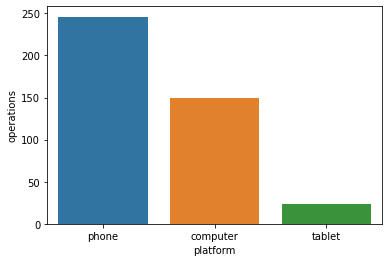

In [38]:
sns.barplot(data=platform_premium_operations.reset_index(), x='platform', y='operations')

In [37]:
print(f'Премиумные клиенты предпочитают платформу {popular_platform_premium}.')

Премиумные клиенты предпочитают платформу phone.


### 5 задание
Визуализируйте распределение возраста клиентов в зависимости от типа клиента (премиум или нет)

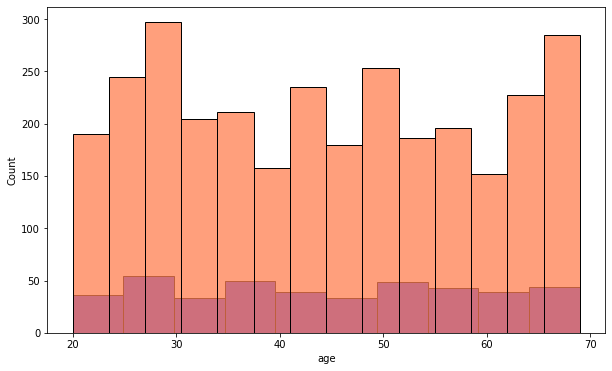

In [82]:
plt.figure(figsize=(10, 6))
sns.histplot(users_logs.query('premium == True').age, color='blue')
sns.histplot(users_logs.query('premium == False').age, color='coral')
plt.show()

### 6 задание
Постройте график распределения числа успешных операций

In [57]:
# Число успешных операций у каждого клиента 
client_success = users_logs.groupby('client') \
    .agg({'success':'sum'})
client_success.head()

,success
client,
40,1
75,1
81,1
132,1
164,1


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


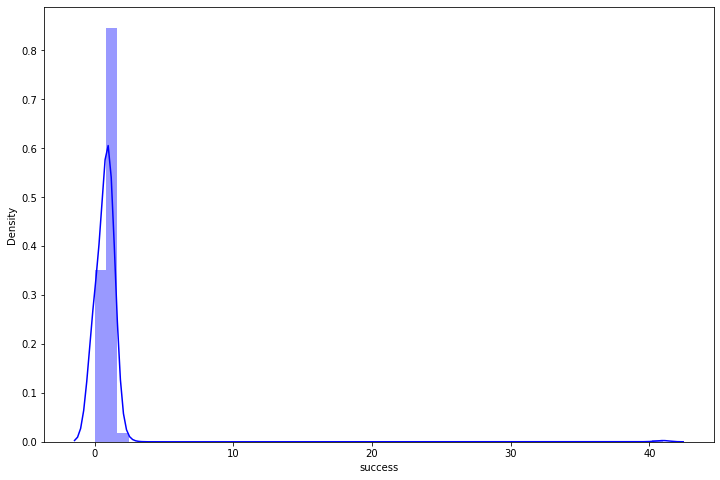

In [81]:
# Создаем фигуру
fig, ax = plt.subplots(figsize=(12, 8))

# Строим гистограмму распределения
sns.distplot(client_success['success'], ax=ax, kde=True, color='blue')

Бóльшая часть наблюдений сосредоточена в левой части графика - распределение ненормально.


### 7 задание
Визуализируйте число успешных операций, сделанных на платформе computer, в зависимости от возраста, используя sns.countplot (x – возраст, y – число успешных операций). Клиенты какого возраста совершили наибольшее количество успешных действий?

In [86]:
computer_success = users_logs.query('platform == "computer" and success == True') 

Text(0, 0.5, 'Число успешных операций')

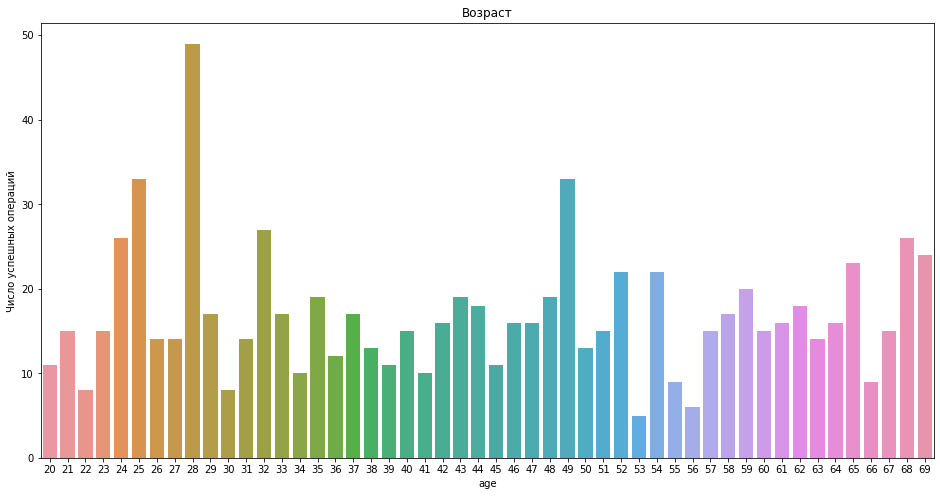

In [89]:
plt.figure(figsize=(16, 8))
sns.countplot(data=computer_success, x='age')
plt.title('Возраст')
plt.ylabel('Число успешных операций')

Как видно из графика, 28-летние клиенты совершили наибольшее количество успешных действий.

